In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import gget

os.chdir("..")
print(os.getcwd())

/home/yichaocai/work/indrop


### Inspect dropest outputs

In [3]:
sample = "test"
print(f"--- reading sample: {sample}")
cell_path = f"./output_v1_2/Estimated_counts/{sample}.est.cells.tsv"
gene_path = f"./output_v1_2/Estimated_counts/{sample}.est.genes.tsv"
mtx_path = f"./output_v1_2/Estimated_counts/{sample}.est.mtx"
rds_path = f"./output_v1_2/Estimated_counts/{sample}.est.rds"

df_cell = pd.read_table(cell_path, names=['cell'])
df_gene = pd.read_table(gene_path, names=['gene'])
print(f"cell num: {df_cell.shape[0]}; gene num: {df_gene.shape[0]}")

with open(mtx_path, 'r') as mtx:
    for i, l in enumerate(mtx):
        if(i==1):
            # print(l)
            mtx_row, mtx_col, mtx_nonZero = [int(_) for _ in l.strip().split(" ")]
            break
print(f"Matrix row, col, and nonZeroEntry: {mtx_row}, {mtx_col}, {mtx_nonZero}")

if(df_cell.shape[0] == mtx_col and df_gene.shape[0] == mtx_row):
    print("--- gene, cell, count matrix dimension check passed.")
    df_mtx = pd.read_table(mtx_path, sep=" ", skiprows=2, names=["row", "column", "count"])

--- reading sample: test
cell num: 251; gene num: 16770
Matrix row, col, and nonZeroEntry: 16770, 251, 116892
--- gene, cell, count matrix dimension check passed.


### Reconstruct gene-cell matrix

In [4]:
def reconstructMatrix(df_row, df_col, mtx_path):
    with open(mtx_path, 'r') as mtx:
        for i, l in enumerate(mtx):
            if(i == 0):
                continue
            elif(i == 1):
                # Initialize numpy array.
                mtx_row, mtx_col, mtx_nonZero = [int(_) for _ in l.strip().split(" ")]
                array = np.zeros((mtx_row, mtx_col), dtype=int)
            else:
                # In MatrixMarket format, the row and column are 1-based. Converting to 0-based.
                _mtx_row, _mtx_col, _mtx_nonZero = [int(_) for _ in l.strip().split(" ")]
                array[_mtx_row-1][_mtx_col-1] = _mtx_nonZero
    df = pd.DataFrame(array, columns = df_col.cell.tolist(), index=df_row.gene.tolist())
    return(df, array)


In [5]:
df, cnt_array = reconstructMatrix(df_gene, df_cell, mtx_path)
# print(np.max(cnt_array))

# Check max count index
print("--- Checking max count index")
max_idx = np.unravel_index(np.argmax(cnt_array, axis=None), cnt_array.shape)
max_gene = df_gene.iloc[max_idx[0],].tolist()[0]
max_cell = df_cell.iloc[max_idx[1],].tolist()[0]
print(max_gene, max_cell)

max_idx2 = np.unravel_index(df.values.argmax(), df.shape)
tmp = df.iloc[[max_idx2[0]], [max_idx2[1]]]
if(tmp.index.tolist()[0]==max_gene and tmp.columns.tolist()[0]==max_cell):
    print("Max count gene and cell index check passed.")


--- Checking max count index
ENST00000396895.3 TCATCCTTTTTATCAC
Max count gene and cell index check passed.


### Explore matrix

In [6]:
# Transform matrix in to long format
df_long = df.reset_index(drop=False).melt(id_vars=['index']).rename(columns={'index':'gene', 'variable':'cell', 'value': 'count'})
df_long.sort_values(['count'], ascending=False)

,gene,cell,count
3941182,ENST00000396895.3,TCATCCTTTTTATCAC,48
3957747,ENST00000362079.2,GAGACGATGGCTGGTGCA,47
4058367,ENST00000362079.2,GACACGGACTCGGGTAGT,44
3286947,ENST00000362079.2,GATAACCATCGTCCAAAG,42
1677027,ENST00000362079.2,GATTGGCGTTTTAAGCGT,39
...,...,...,...
1480607,ENST00000708561.1,GACGCCTTGAAAGTAATC,0
1480608,ENST00000456172.5,GACGCCTTGAAAGTAATC,0
97350,ENST00000480224.1,TGAAACACACGCATACATT,0
1480610,ENST00000704582.1,GACGCCTTGAAAGTAATC,0


#### Aggregate per cell

/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


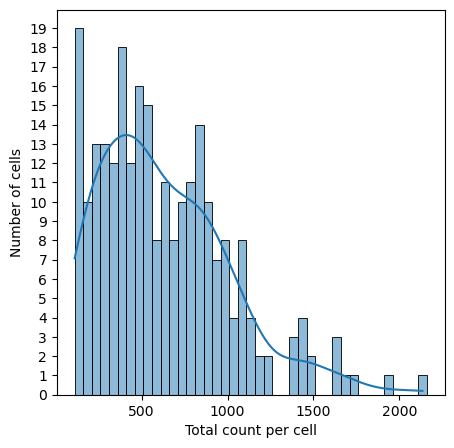

In [7]:
# Cells with most total count across all genes
plot_df = (df_long
 .groupby(['cell'])
 .agg(total_count=('count', 'sum'), max_count=('count', 'max'))
 .sort_values(['total_count'], ascending=False)
 .reset_index()
)

# The majority of the cells have <1000 transcripts.
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=plot_df, x="total_count", kde=True, binwidth=50, ax = ax)
ax.set_xlabel("Total count per cell")
ax.set_ylabel("Number of cells")
ax.set_yticks(range(int(ax.get_yticks().max())))

#### Aggregate per gene

/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of genes')

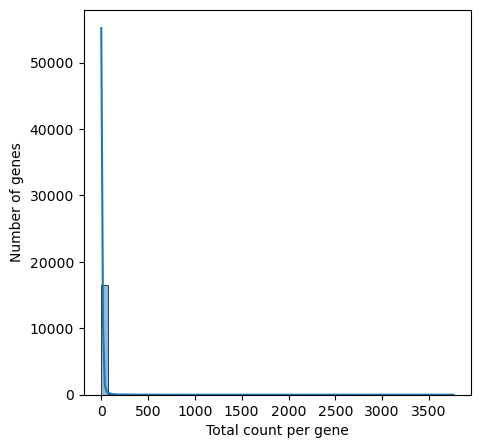

In [8]:
# Gene with total count across all cell
plot_df = (df_long
 .groupby(['gene'])
 .agg(total_count=('count', 'sum'), max_count=('count', 'max'), min_count=('count', 'min'))
 .sort_values(['total_count'], ascending=False)
 .reset_index()
)

# Long tail of gene quantification.
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=plot_df, x="total_count", kde=True, bins=50, ax = ax)
ax.set_xlabel("Total count per gene")
ax.set_ylabel("Number of genes")
# ax.set_yticks(range(int(ax.get_yticks().max())))


In [30]:
def geneGO(df, total_count=500, max_count=10, min_count=0):
    '''Input: gene cell matrix in long form.'''
    df2 = (df
            .groupby(['gene'])
            .agg(total_count=('count', 'sum'), max_count=('count', 'max'), min_count=('count', 'min'))
            .sort_values(['total_count'], ascending=False)
            .reset_index()
            )
    query = f'total_count >= {total_count} & max_count >= {max_count} & min_count >= {min_count}'
    print(f'--- Threshold in filtering genes for GO analysis: {query}')
    selected_genes = (df2
                      .query(query) 
                      )
    print(f'--- Number of gene after filtering: {selected_genes.shape[0]}')

    selected_genes_info = gget.info(selected_genes.gene.values.tolist())
    
    non_MT_genes = (selected_genes_info
                    .query('~ seq_region_name.str.contains("_")') # Filter out genes mapped to scaffold chromosomes
                    .query('~ (seq_region_name == "MT")') # Filter out MT genes
                    .ensembl_id
                    .tolist()
                    ) 
    
    print(f'--- Non MT genes: {len(non_MT_genes)}')
    gget.enrichr(non_MT_genes, ensembl=True, database="ontology", plot=True)

    return(non_MT_genes)

In [31]:
geneGO(df_long, 200, 0, 0)

Tue Sep 12 10:34:47 2023 INFO We noticed that you may have passed a version number with your Ensembl ID.
Please note that gget info will always return information linked to the latest Ensembl ID version (see 'ensembl_id').


--- Threshold in filtering genes for GO analysis: total_count >= 200 & max_count >= 0 & min_count >= 0
--- Number of gene after filtering: 101


Tue Sep 12 10:35:55 2023 WARNING No UniProt entry was found for ID ENST00000679031.
Tue Sep 12 10:36:10 2023 WARNING No UniProt entry was found for ID ENST00000709241.
Tue Sep 12 10:36:20 2023 WARNING No UniProt entry was found for ID ENST00000474582.
Tue Sep 12 10:36:23 2023 WARNING No reviewed UniProt results were found for ID ENST00000697754. Returning all unreviewed results.
Tue Sep 12 10:36:50 2023 WARNING No UniProt entry was found for ID ENST00000568952.
Tue Sep 12 10:37:06 2023 WARNING No reviewed UniProt results were found for ID ENST00000406022. Returning all unreviewed results.
Tue Sep 12 10:37:14 2023 WARNING No reviewed UniProt results were found for ID ENST00000624069. Returning all unreviewed results.
Tue Sep 12 10:37:23 2023 WARNING No UniProt entry was found for ID ENST00000633925.
Tue Sep 12 10:37:35 2023 WARNING No reviewed UniProt results were found for ID ENST00000221975. Returning all unreviewed results.
Tue Sep 12 10:37:38 2023 WARNING No reviewed UniProt results

--- Non MT genes: 87


Tue Sep 12 10:52:11 2023 INFO Performing Enichr analysis on the following gene symbols: HBG2-201, EEF1A1-223, RPL23-203, H4C3-201, RPS8-205, RPSA-219, RPS11-201, RPS5-201, RPS12-201, FTH1-201, nan, RPS15-209, RPL10-203, HBE1-203, RPL13A-214, H1-2-201, RPS19-201, RPL15-215, RPL41-202, RPL10-205, RPS15A-203, RPL35-201, TUBA1B-202, RPL14-208, RPS23-203, RPL32-201, RPL8-208, RPLP1-202, RANBP1-201, RPLP0-225, RPS17-209, RPL28-207, RPL27A-204, RPL17-219, RPL6-201, FTL-201, RPS14-207, RPL3P4-201, RPL4-209, RPL34-202, RPL18A-204, RPLP0P9-201, RPS8-202, RPL13-211, RPS18-230, RPSA-201, RPS27-205, RPL18-214, CHCHD2-201, YBX1-203, RPS16-201, RPLP1-201, HSP90AA1-201, RPS20-201, RPL27-201, HSP90AB1-203, RPS10-209, RPL23A-201, RACK1-205, FAU-207, HMGB1-205, RPLP2-201, GAPDH-211, RPS27A-201, RPL7-203, RPL37A-202, RPL10A-201, PTMA-202, RPL12-205, RPL37-202, RPS7-209, EEF1A1-201, PRDX1-203, UBA52-209, ATP5MC3-203, FUT8-205, RPL26-213, HSPA8-221, PPIA-210, RPL39-201, RAN-211, H3P6-201, RPS21-201, HNRNPA1

['ENST00000336906.6',
 'ENST00000679031.1',
 'ENST00000394332.5',
 'ENST00000377803.4',
 'ENST00000474582.1',
 'ENST00000697754.1',
 'ENST00000270625.7',
 'ENST00000196551.8',
 'ENST00000230050.4',
 'ENST00000273550.12',
 'ENST00000568952.1',
 'ENST00000592588.7',
 'ENST00000406022.6',
 'ENST00000396895.3',
 'ENST00000624069.3',
 'ENST00000343677.4',
 'ENST00000221975.6',
 'ENST00000644684.1',
 'ENST00000501597.3',
 'ENST00000428169.1',
 'ENST00000563390.5',
 'ENST00000348462.6',
 'ENST00000336023.9',
 'ENST00000479563.5',
 'ENST00000504293.5',
 'ENST00000273223.10',
 'ENST00000529163.5',
 'ENST00000357790.5',
 'ENST00000331821.8',
 'ENST00000552292.5',
 'ENST00000647841.1',
 'ENST00000558815.5',
 'ENST00000526562.5',
 'ENST00000584364.5',
 'ENST00000202773.14',
 'ENST00000331825.11',
 'ENST00000521466.5',
 'ENST00000417615.1',
 'ENST00000565723.1',
 'ENST00000394667.8',
 'ENST00000599898.5',
 'ENST00000518938.1',
 'ENST00000396651.8',
 'ENST00000563270.5',
 'ENST00000439602.7',
 'ENST